# Non-parametric regression

### Necessary imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

#### Implementing the Nadaraya-Watson kernel regression using the following class

In [2]:
class NadarayaWatson:
    def __init__(self, kernel_func, bandwidth):
        self.kernel_func = kernel_func
        self.bandwidth = bandwidth
        self.X = None
        self.Y = None

    def fit(self,X,Y):
        self.X = np.array(X)
        self.Y = np.array(Y)
        return self
    
    def predict(self, X_new):
        predictions = []
        for x in X_new:
            try:
                weights = self.kernel_func((x-self.X)/self.bandwidth)                   
                if np.sum(weights) == 0:
                    predictions.append(np.mean(self.Y))
                else:
                    prediction = np.sum(weights*self.Y)/np.sum(weights)
                    predictions.append(prediction)             
                
            except:
                print(x, self.X,self.bandwidth,"error")
            
        return np.array(predictions)

### Kernel Functions

In [3]:
def gaussian_kernel(x):
    return np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)

def epanechnikov_kernel(x):
    return 0.75*(1-x**2)*(np.abs(x)<=1)

### Risk function

In [4]:
def risk(Y_true,Y_pred):
    return np.mean((Y_true-Y_pred)**2)

### K-Fold Cross Validation implemented from scratch

In [5]:
def k_fold_cross_validation(X,Y,kernel_func,bandwidth,k=5):
    n = len(X)
    fold_size = n//k
    indices = np.arange(n)
    np.random.shuffle(indices)

    risks = []
    for i in range(k):
        val_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate([indices[:i*fold_size],indices[(i+1)*fold_size:]])
        X_train, X_val = X[train_idx], X[val_idx]
        Y_train, Y_val = Y[train_idx], Y[val_idx]

        model = NadarayaWatson(kernel_func, bandwidth)
        model.fit(X_train,Y_train)
        Y_pred = model.predict(X_val)
        risks.append(risk(Y_val,Y_pred))

    return np.mean(risks)


### Split function

In [6]:
def train_dev_split(X, y, train_ratio=0.75, random_seed=100):
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    
    np.random.seed(random_seed)
    
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    train_size = int(n_samples * train_ratio)
    
    train_indices = indices[:train_size]
    dev_indices = indices[train_size:]
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_dev = X[dev_indices]
    y_dev = y[dev_indices]
    
    return (X_train, y_train), (X_dev, y_dev)

### Function to calculate the optimal bandwidth

In [7]:
def optimal_bandwidth(X_dev,Y_dev,kernel_func,bandwidths):
    risks = []
    for h in bandwidths:
        risk = k_fold_cross_validation(X_dev,Y_dev,kernel_func,h)
        risks.append(risk)
    optimal = np.argmin(risks)
    return bandwidths[optimal], np.array(risks)

### Reading the csv

In [8]:
df = pd.read_csv('Forensic_glass_data.csv')
df.columns
X = df['Al']
Y = df['RI']
X = (X-np.mean(X))/np.std(X)

#### Bandwidths that we will check

In [9]:
bandwidths = np.logspace(-1,1,100)
(X_train, Y_train), (X_dev, Y_dev) = train_dev_split(X,Y)

### 1. Regression using Gaussian kernel

Optimal value of the bandwidth is  0.33516026509388425


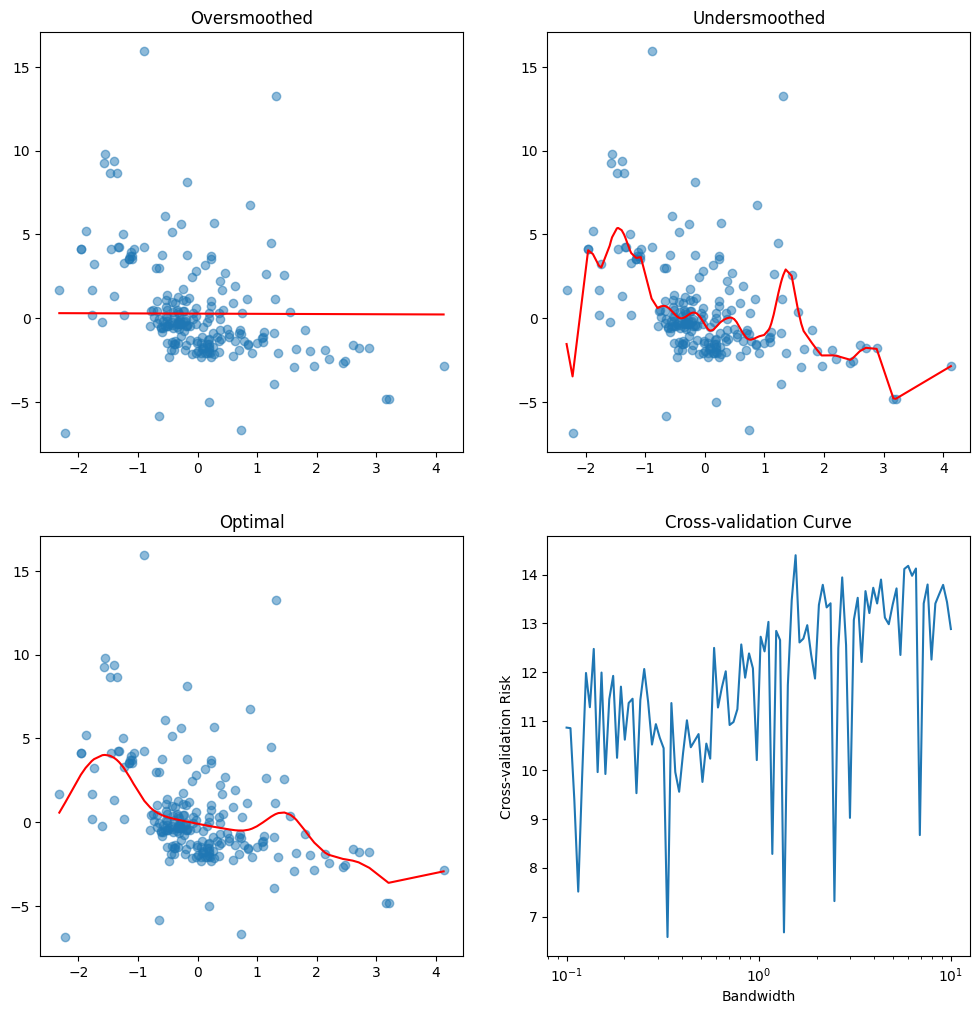

In [10]:
gaussian_optimal_h, gaussian_risks = optimal_bandwidth(X_dev,Y_dev,gaussian_kernel,bandwidths)

fig, axes = plt.subplots(2,2, figsize=(12,12))

model_gaussian = NadarayaWatson(gaussian_kernel,bandwidths[-1])
model_gaussian.fit(X_train,Y_train)
X_sorted = np.sort(X)
Y_pred = model_gaussian.predict(X_sorted)
axes[0,0].scatter(X,Y,alpha=0.5)
axes[0,0].plot(X_sorted,Y_pred,'r-')
axes[0,0].set_title('Oversmoothed')

model_gaussian = NadarayaWatson(gaussian_kernel,bandwidths[0])
model_gaussian.fit(X_train,Y_train)
X_sorted = np.sort(X)
Y_pred = model_gaussian.predict(X_sorted)
axes[0,1].scatter(X,Y,alpha=0.5)
axes[0,1].plot(X_sorted,Y_pred,'r-')
axes[0,1].set_title('Undersmoothed')

model_gaussian = NadarayaWatson(gaussian_kernel,gaussian_optimal_h)
model_gaussian.fit(X_train,Y_train)
X_sorted = np.sort(X)
Y_pred = model_gaussian.predict(X_sorted)
axes[1,0].scatter(X,Y,alpha=0.5)
axes[1,0].plot(X_sorted,Y_pred,'r-')
axes[1,0].set_title('Optimal')

axes[1, 1].plot(bandwidths, gaussian_risks)
axes[1, 1].set_xscale('log')
axes[1, 1].set_xlabel('Bandwidth')
axes[1, 1].set_ylabel('Cross-validation Risk')
axes[1, 1].set_title('Cross-validation Curve')

print("Optimal value of the bandwidth is ", gaussian_optimal_h)

### Gaussian using epanechnikov kernel

Optimal value of the bandwidth is  0.5857020818056667


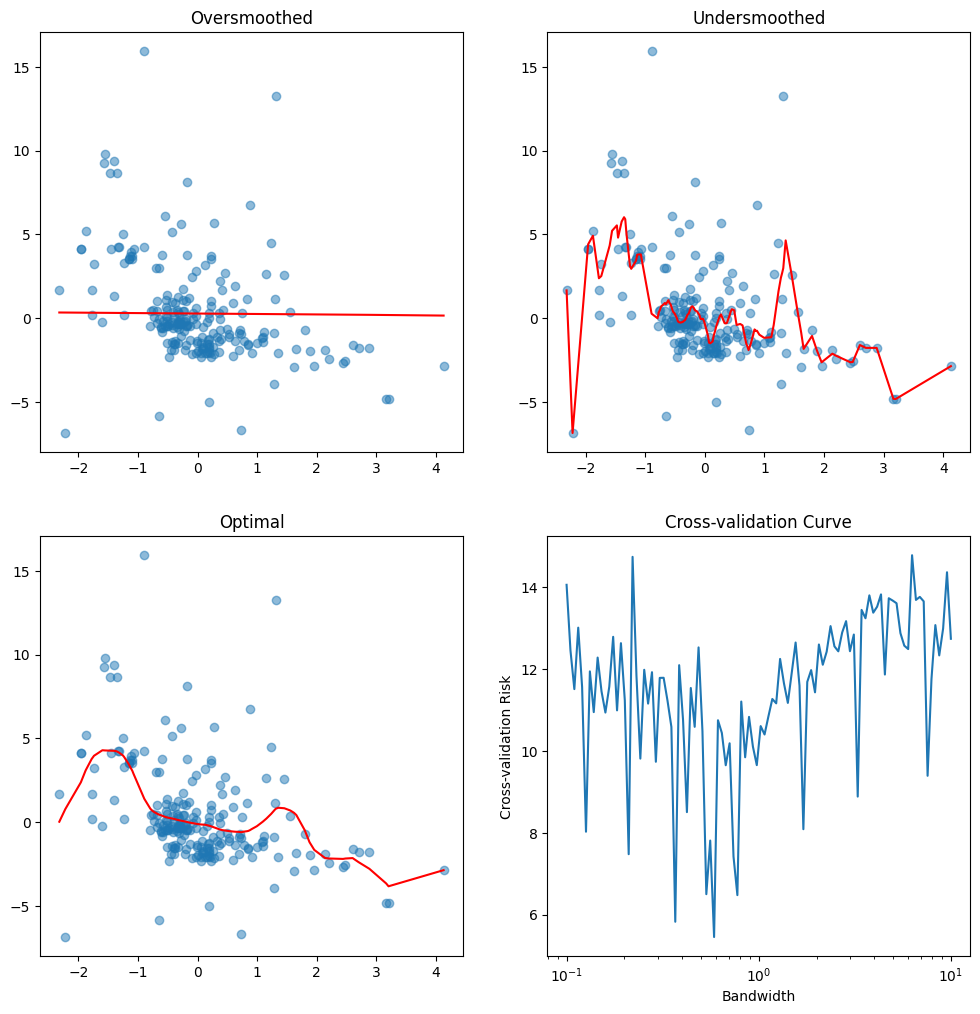

In [11]:
epanechnikov_optimal_h, epanechnikov_risks = optimal_bandwidth(X_dev,Y_dev,epanechnikov_kernel,bandwidths)

fig, axes = plt.subplots(2,2, figsize=(12,12))

epanechnikov_model = NadarayaWatson(epanechnikov_kernel,bandwidths[-1])
epanechnikov_model.fit(X_train,Y_train)
X_sorted = np.sort(X)
Y_pred = epanechnikov_model.predict(X_sorted)
axes[0,0].scatter(X,Y,alpha=0.5)
axes[0,0].plot(X_sorted,Y_pred,'r-')
axes[0,0].set_title('Oversmoothed')

epanechnikov_model = NadarayaWatson(epanechnikov_kernel,bandwidths[0])
epanechnikov_model.fit(X_train,Y_train)
X_sorted = np.sort(X)
Y_pred = epanechnikov_model.predict(X_sorted)
axes[0,1].scatter(X,Y,alpha=0.5)
axes[0,1].plot(X_sorted,Y_pred,'r-')
axes[0,1].set_title('Undersmoothed')

epanechnikov_model = NadarayaWatson(epanechnikov_kernel,epanechnikov_optimal_h)
epanechnikov_model.fit(X_train,Y_train)
X_sorted = np.sort(X)
Y_pred = epanechnikov_model.predict(X_sorted)
axes[1,0].scatter(X,Y,alpha=0.5)
axes[1,0].plot(X_sorted,Y_pred,'r-')
axes[1,0].set_title('Optimal')

axes[1, 1].plot(bandwidths, epanechnikov_risks)
axes[1, 1].set_xscale('log')
axes[1, 1].set_xlabel('Bandwidth')
axes[1, 1].set_ylabel('Cross-validation Risk')
axes[1, 1].set_title('Cross-validation Curve')

print("Optimal value of the bandwidth is ", epanechnikov_optimal_h)
